#Final Proyect - Deep Spectra corn proteins prediction
##Rafael Barrera Quiroz C.C. 1035433047

###En este proyecto, se realiza una implementación de varios modelos basados en redes neuronales, para la predicción de caracteristicas propias del maiz, a partir de una base de datos espectroscopicos de infrarojo cercano y visible, de este producto. Dichos modelos son tomados del articulo _Deep spectra corn proteins prediction_.

In [1]:
pip install BaselineRemoval

In [2]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Concatenate, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from BaselineRemoval import BaselineRemoval
from scipy.signal import savgol_filter
from sklearn.metrics import confusion_matrix
from scipy.optimize import curve_fit

In [3]:
mat=loadmat('corn.mat')

In [4]:
mat['information']

array(['This data set consists of 80 samples of corn measured on    ',
       '3 different NIR spectrometers. The wavelength range is      ',
       '1100-2498nm at 2 nm intervals (700 channels). The moisture, ',
       'oil, protein and starch values for each of the samples is   ',
       'also included. A number of NBS glass standards were also    ',
       'measured on each instrument. The data was originally taken  ',
       'at Cargill. Many thanks for Mike Blackburn for letting us   ',
       'distribute it.                                              ',
       '                                                            ',
       'The variables in this data set are described below:         ',
       '   information: [20x59  char  ] This field                  ',
       '        m5spec: [80x700 dataset] Spectra on instrument m5   ',
       '       mp5spec: [80x700 dataset] Spectra on instrument mp5  ',
       '       mp6spec: [80x700 dataset] Spectra on instrument mp6  ',
      

###Se implementan en total cuatro modelos de redes neuronales; los primeros tres de ellos son entrenados y evaluados con un conjunto de datos que ha recibido un preprocesamiento de tres etapas, a saber, _linear baseline correction_, _multiplicative scatter correction_, y _noise reduction_, mientras el último modelo ha sido implementado en base a datos con y sin preprocesamiento. Los datos son provenientes de tres espectroscopios distintos, donde cada espectroscopio cuenta con un _dataset_ de 80 muestras con 700 canales cada una de ellas. Para garantizar la mayor generalización posible, se construye de manera aleatoria un nuevo _dataset_ el cual cuenta tambien con 80 muestras, cada una de ellas perteneciente a algún espectroscopio. En vista que el uso completo de todas las muestras de los tres espectroscopios generaba modelos con bajo rendimiento, se optó por no utilizar el conjunto completo de muestras. El conjunto de _features_ a predecir son Moisture, oil, protein, starch. Los modelos implementados solo predicen una sola de estas caracteristicas, la cual es elegida de manera aleatoria.

##Data without preprocessing

In [5]:
df_m5=pd.DataFrame(data=mat['m5spec'][0][0][7], index=mat['m5spec'][0][0][12][0][0][0], columns=mat['m5spec'][0][0][12][1][0][0])
df_mp5=pd.DataFrame(data=mat['mp5spec'][0][0][7], index=mat['mp5spec'][0][0][12][0][0][0], columns=mat['mp5spec'][0][0][12][1][0][0])
df_mp6=pd.DataFrame(data=mat['mp6spec'][0][0][7], index=mat['mp6spec'][0][0][12][0][0][0], columns=mat['mp6spec'][0][0][12][1][0][0])

In [6]:
df_all=pd.DataFrame(np.vstack((np.vstack((df_m5,df_mp5)), df_mp6)), index=np.arange(1,241), columns=np.arange(1,701))

In [7]:
moisture=mat['propvals'][0][0][7][:,0]
moisture=np.hstack((np.hstack((moisture,moisture)),moisture))

oil=mat['propvals'][0][0][7][:,1]
oil=np.hstack((np.hstack((oil,oil)),oil))

protein=mat['propvals'][0][0][7][:,2]
protein=np.hstack((np.hstack((protein,protein)),protein))

starch=mat['propvals'][0][0][7][:,3]
starch=np.hstack((np.hstack((starch,starch)),starch))

In [8]:
df_all=df_all.assign(**{'moisture':moisture,'oil':oil,'protein':protein,'starch':starch})

In [9]:
df_all_target=df_all[df_all.columns[-4:]]
df_all_data=df_all[df_all.columns[:700]]

In [10]:
features=['moisture','oil','protein','starch']
f=np.random.randint(0,4)

In [11]:
X_data_all=df_all_data.to_numpy()
y_data_all=df_all_target[features[f]].to_numpy()

In [12]:
r=np.random.randint(1,240,80)
X_data_all=X_data_all[r]
y_data_all=y_data_all[r]

In [13]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_data_all, y_data_all, test_size=0.2,random_state=1234)

In [14]:
X_train_all_reshaped=X_train_all.reshape(X_train_all.shape[0], X_train_all.shape[1], 1)
X_test_all_reshaped=X_test_all.reshape(X_test_all.shape[0], X_test_all.shape[1], 1)

##Preprocesing Data
##Linear Baseline Correction (LBC)

In [15]:
df_m5_BL=BaselineRemoval(df_m5.to_numpy()[0]).ZhangFit()
for i in range(1,df_m5.shape[0]):
    df_m5_BL=np.vstack((df_m5_BL,BaselineRemoval(df_m5.to_numpy()[i]).ZhangFit()))

df_mp5_BL=BaselineRemoval(df_m5.to_numpy()[0]).ZhangFit()
for i in range(1,df_mp5.shape[0]):
    df_mp5_BL=np.vstack((df_mp5_BL,BaselineRemoval(df_mp5.to_numpy()[i]).ZhangFit()))

df_mp6_BL=BaselineRemoval(df_mp6.to_numpy()[0]).ZhangFit()
for i in range(1,df_mp6.shape[0]):
    df_mp6_BL=np.vstack((df_mp6_BL,BaselineRemoval(df_mp6.to_numpy()[i]).ZhangFit()))

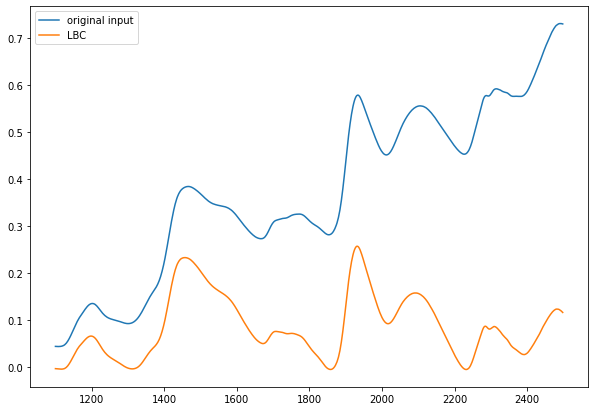

In [16]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(1100,2499,2),df_m5.to_numpy()[0])
plt.plot(np.arange(1100,2499,2),df_m5_BL[0])
plt.legend(['original input','LBC'])
plt.show()

##Multiplicative Scatter Correction (MSC)

In [17]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]
 
    return data_msc

In [18]:
df_m5_MSC=msc(df_m5_BL)
df_mp5_MSC=msc(df_mp5_BL)
df_mp6_MSC=msc(df_mp6_BL)

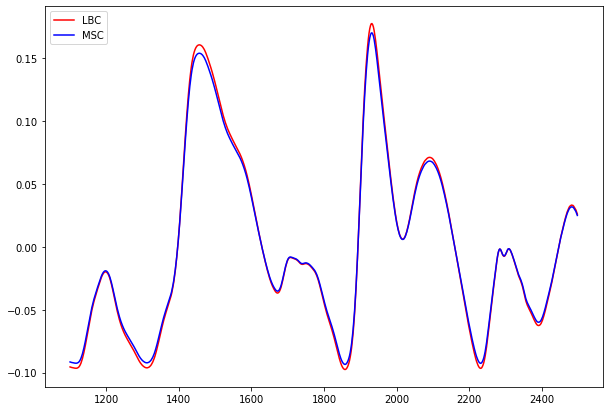

In [19]:
plt.figure(figsize=(10,7))
#plt.plot(np.arange(1100,2499,2),df_m5.to_numpy()[5],'k')
plt.plot(np.arange(1100,2499,2),df_m5_BL[5],'r')
plt.plot(np.arange(1100,2499,2),df_m5_MSC[5],'b')
plt.legend(['LBC','MSC'],loc='upper left')
plt.show()

##Noise Removal

In [20]:
df_m5_NR=savgol_filter(df_m5_MSC,51,2)
df_mp5_NR=savgol_filter(df_mp5_MSC,51,2)
df_mp6_NR=savgol_filter(df_mp6_MSC,51,2)

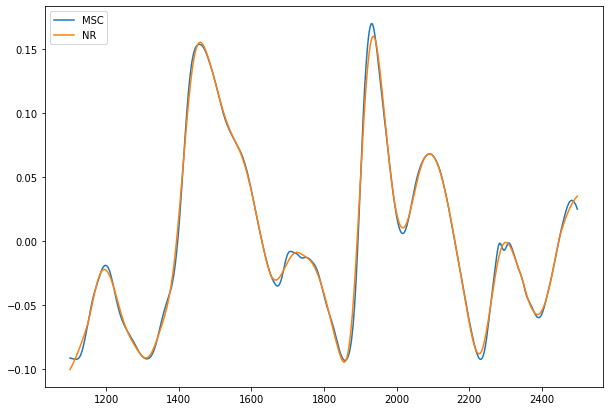

In [21]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(1100,2499,2),df_m5_MSC[5])
plt.plot(np.arange(1100,2499,2),df_m5_NR[5])
plt.legend(['MSC','NR'], loc='upper left')
plt.show()

In [22]:
df_m5_NR=pd.DataFrame(data=df_m5_NR, index=mat['m5spec'][0][0][12][0][0][0], columns=mat['m5spec'][0][0][12][1][0][0])
df_mp5_NR=pd.DataFrame(data=df_mp5_NR, index=mat['mp5spec'][0][0][12][0][0][0], columns=mat['m5spec'][0][0][12][1][0][0])
df_mp6_NR=pd.DataFrame(data=df_mp6_NR, index=mat['mp6spec'][0][0][12][0][0][0], columns=mat['m5spec'][0][0][12][1][0][0])

In [23]:
df_m5=df_m5_NR.assign(**{'moisture':mat['propvals'][0][0][7][:,0],'oil':mat['propvals'][0][0][7][:,1],\
                'protein':mat['propvals'][0][0][7][:,2],'starch':mat['propvals'][0][0][7][:,3]})
df_mp5=df_mp5_NR.assign(**{'moisture':mat['propvals'][0][0][7][:,0],'oil':mat['propvals'][0][0][7][:,1],\
                'protein':mat['propvals'][0][0][7][:,2],'starch':mat['propvals'][0][0][7][:,3]})
df_mp6=df_mp6_NR.assign(**{'moisture':mat['propvals'][0][0][7][:,0],'oil':mat['propvals'][0][0][7][:,1],\
                'protein':mat['propvals'][0][0][7][:,2],'starch':mat['propvals'][0][0][7][:,3]})

In [24]:
df_all_pd=np.vstack((np.vstack((df_m5,df_mp5)),df_mp6))

In [25]:
df_all_pd=pd.DataFrame(data=df_all_pd, index=np.arange(1,241), columns=np.append(np.arange(1,701),[features]))

In [26]:
df_all_pd_target=df_all_pd[df_all_pd.columns[-4:]]
df_all_pd_data=df_all_pd[df_all_pd.columns[:700]]

In [27]:
X_data_all_pd=df_all_pd_data.to_numpy()
y_data_all_pd=df_all_pd_target[features[f]].to_numpy()

In [28]:
X_data_all_pd=X_data_all_pd[r]
y_data_all_pd=y_data_all_pd[r]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_data_all_pd, y_data_all_pd, test_size=0.2,random_state=1234)

In [30]:
X_train_reshaped=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
def compile_model(model):
  model.compile(optimizer='adam',loss='mse',metrics=['mape'])

##Model 1
###Formado por una capa convolucional de una dimensión y una capa con 200 neuronas

In [ ]:
def Model_1(input_shape, wd):
  model=Sequential([InputLayer(input_shape=input_shape),
              Conv1D(filters=8, kernel_size=3, activation='relu', name='Conv_0'),
              Flatten(name='Flatten'),
              Dense(units=200, kernel_regularizer=regularizers.l1(wd), activation='relu'),
              Dense(units=1, activation='linear')
              
  ])
  return model

In [ ]:
model=Model_1(X_train_reshaped[0].shape, 0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_0 (Conv1D)             (None, 698, 8)            32        
                                                                 
 Flatten (Flatten)           (None, 5584)              0         
                                                                 
 dense (Dense)               (None, 200)               1117000   
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,117,233
Trainable params: 1,117,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
compile_model(model)
history=model.fit(X_train_reshaped,y_train,batch_size=64,epochs=50,validation_split=0.15,verbose=0)

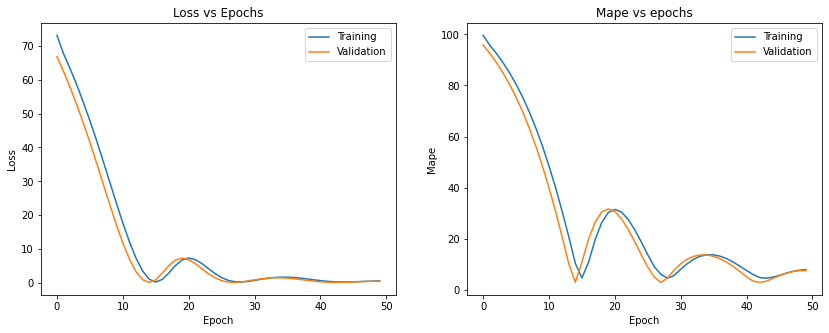

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
train_result=dict(zip(model.metrics_names,model.evaluate(X_train_reshaped, y_train)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(X_test_reshaped, y_test)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 1s 15ms/step - loss: 0.5466 - mape: 7.8635
Train_mape:7.86 	 Train_loss:0.55 

1/1 [==============================] - 0s 46ms/step - loss: 0.5507 - mape: 7.8713
Test_mape:7.87 	 Test_loss:0.55


In [ ]:
n=np.random.randint(0,X_test_reshaped.shape[0],10)
print('feature= '+str(features[f]),'\n')
for i in range(10):
  prediction=model.predict(X_test_reshaped[n[i]:n[i]+1])[0][0]
  real=y_test[n[i]]
  print(f'predicted value:{prediction:.2f}','\t',f'real value:{real:.2f}')

feature= protein 

predicted value:9.17 	 real value:8.36
predicted value:9.13 	 real value:7.88
predicted value:9.14 	 real value:8.23
predicted value:9.16 	 real value:8.27
predicted value:9.12 	 real value:8.48
predicted value:9.13 	 real value:7.88
predicted value:9.18 	 real value:8.23
predicted value:9.14 	 real value:9.69
predicted value:9.12 	 real value:8.48
predicted value:9.11 	 real value:8.84


In [ ]:
def my_func(x,a1,a0):
  return a1*x+a0

p0=np.array([1.0,1.0])
popt,pcov = curve_fit(my_func,y_test,model.predict(X_test_reshaped).reshape(16,),p0,method='lm')
xfit=np.linspace(y_test.min()-0.2,y_test.max()+0.2,50)
yfit=my_func(xfit,popt[0],popt[1])

r^2 score:-1.41 



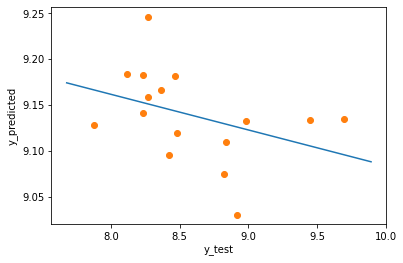

In [ ]:
print(f'r^2 score:{r2_score(y_test, model.predict(X_test)):.2f}', '\n')
plt.plot(xfit, yfit)
plt.plot(y_test, model.predict(X_test_reshaped), 'o')
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.show()

##Model 2
###Formado por una red neuronal no lineal y una capa con 200 neuronas

In [ ]:
def Model_2(input_shape, wd):
  model=Sequential([InputLayer(input_shape=input_shape),
              Flatten(name='Flatten'),
              Dense(units=200, activation='relu'),
              Dense(units=1, activation='linear')
              
  ])
  return model

In [ ]:
def inception_module(layer_in):
  Conv1=Conv1D(filters=8, kernel_size=3, activation='relu')(layer_in)
  Conv2_1=Conv1D(filters=4, kernel_size=3, activation='relu')(Conv1)
  Conv2_2=Conv1D(filters=4, kernel_size=3, activation='relu')(Conv1)
  Conv2_3=Conv1D(filters=4, kernel_size=3, activation='relu')(Conv1)
  layer_out=np.concatenate([Conv2_1,Conv2_2,Conv2_3],-1)
  return layer_out

In [ ]:
layer_out_train=inception_module(X_train_reshaped)
layer_out_test=inception_module(X_test_reshaped)

In [ ]:
model=Model_2(layer_out_train[0].shape, 0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 8352)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               1670600   
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,670,801
Trainable params: 1,670,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
compile_model(model)
history=model.fit(layer_out_train,y_train,batch_size=64,epochs=50,validation_split=0.15,verbose=0)

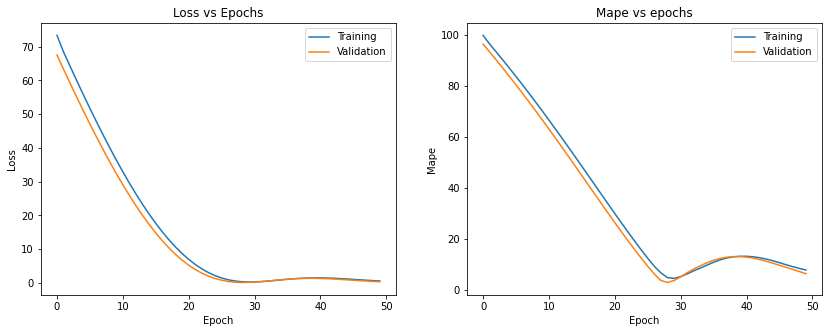

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
train_result=dict(zip(model.metrics_names,model.evaluate(layer_out_train, y_train)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(layer_out_test, y_test)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 0s 21ms/step - loss: 0.4526 - mape: 7.1728
Train_mape:7.17 	 Train_loss:0.45 

1/1 [==============================] - 0s 88ms/step - loss: 2.3431 - mape: 17.1347
Test_mape:17.13 	 Test_loss:2.34


In [ ]:
n=np.random.randint(0,layer_out_test.shape[0],10)
print('feature= '+str(features[f]),'\n')
for i in range(10):
  prediction=model.predict(layer_out_test[n[i]:n[i]+1])[0][0]
  real=y_test[n[i]]
  print(f'predicted value:{prediction:.2f}','\t',f'real value:{real:.2f}')

feature= protein 

predicted value:10.12 	 real value:8.23
predicted value:9.92 	 real value:8.82
predicted value:10.09 	 real value:8.47
predicted value:10.01 	 real value:8.48
predicted value:10.07 	 real value:8.27
predicted value:10.01 	 real value:9.45
predicted value:10.01 	 real value:9.69
predicted value:10.01 	 real value:8.99
predicted value:10.09 	 real value:8.47
predicted value:9.99 	 real value:8.84


In [ ]:
popt,pcov = curve_fit(my_func,y_test,model.predict(layer_out_test).reshape(16,),p0,method='lm')
xfit=np.linspace(y_test.min()-0.2,y_test.max()+0.2,50)
yfit=my_func(xfit,popt[0],popt[1])

r^2 score:-9.26 



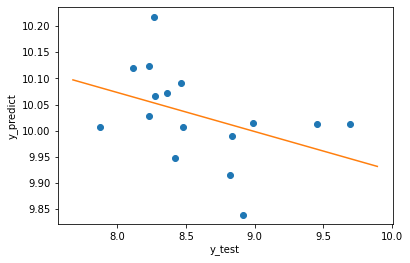

In [ ]:
print(f'r^2 score:{r2_score(y_test, model.predict(layer_out_test)):.2f}', '\n')
plt.plot(y_test, model.predict(layer_out_test), 'o')
plt.plot(xfit, yfit)
plt.xlabel('y_test')
plt.ylabel('y_predict')
plt.show()

##Model 3

In [ ]:
def Model_3(input_shape, wd):
  model=Sequential([InputLayer(input_shape=input_shape),
              Conv1D(filters=6, kernel_size=3, activation='relu', name='Conv_0'),
              MaxPooling1D(pool_size=2),
              Conv1D(filters=16, kernel_size=3, activation='relu', name='Conv_1'),
              MaxPooling1D(pool_size=2),
              Conv1D(filters=32, kernel_size=3, activation='relu', name='Conv_2'),
              Flatten(name='Flatten'),
              Dense(units=100, kernel_regularizer=regularizers.l1(wd), activation='relu'),
              Dense(units=1, activation='linear')
              
  ])
  return model

In [ ]:
model=Model_3(X_train_reshaped[0].shape, 0)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_0 (Conv1D)             (None, 698, 6)            24        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 349, 6)           0         
 )                                                               
                                                                 
 Conv_1 (Conv1D)             (None, 347, 16)           304       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 16)          0         
 1D)                                                             
                                                                 
 Conv_2 (Conv1D)             (None, 171, 32)           1568      
                                                                 
 Flatten (Flatten)           (None, 5472)             

In [ ]:
compile_model(model)
history=model.fit(X_train_reshaped,y_train,batch_size=64,epochs=50,validation_split=0.15,verbose=0)

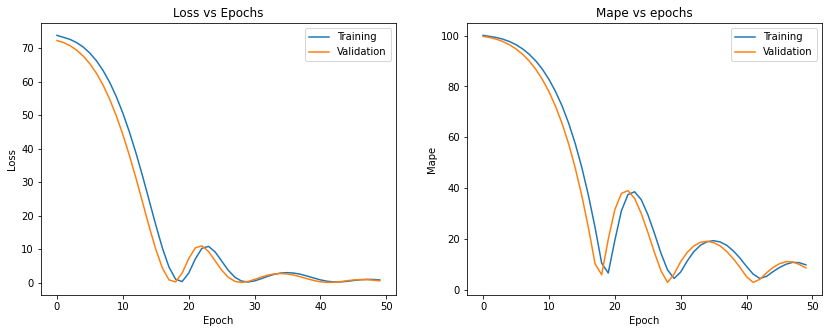

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
train_result=dict(zip(model.metrics_names,model.evaluate(X_train_reshaped, y_train)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(X_test_reshaped, y_test)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 0s 21ms/step - loss: 0.6529 - mape: 8.5924
Train_mape:8.59 	 Train_loss:0.65 

1/1 [==============================] - 0s 31ms/step - loss: 0.6280 - mape: 8.5804
Test_mape:8.58 	 Test_loss:0.63


In [ ]:
n=np.random.randint(0,X_test_reshaped.shape[0],10)
print('feature= '+str(features[f]),'\n')
for i in range(10):
  prediction=model.predict(X_test_reshaped[n[i]:n[i]+1])[0][0]
  real=y_test[n[i]]
  print(f'predicted value:{prediction:.2f}','\t',f'real value:{real:.2f}')

feature= protein 

predicted value:9.21 	 real value:8.92
predicted value:9.23 	 real value:8.84
predicted value:9.23 	 real value:9.69
predicted value:9.21 	 real value:8.48
predicted value:9.22 	 real value:8.82
predicted value:9.21 	 real value:8.48
predicted value:9.24 	 real value:8.27
predicted value:9.24 	 real value:8.27
predicted value:9.21 	 real value:8.48
predicted value:9.21 	 real value:8.92


In [ ]:
popt,pcov = curve_fit(my_func,y_test,model.predict(X_test_reshaped).reshape(16,),p0,method='lm')
xfit=np.linspace(y_test.min()-0.2,y_test.max()+0.2,50)
yfit=my_func(xfit,popt[0],popt[1])

r^2 score:-1.75 



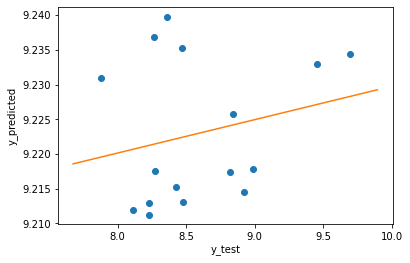

In [ ]:
print(f'r^2 score:{r2_score(y_test, model.predict(X_test_reshaped)):.2f}', '\n')
plt.plot(y_test, model.predict(X_test_reshaped), 'o')
plt.plot(xfit, yfit)
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.show()

##DeepSpectra Model
###preprocesing Data

In [32]:
def Model_DS(input_shape, wd, rate):
  model=Sequential([InputLayer(input_shape=input_shape),
              Flatten(name='Flatten'),
              Dense(units=200,  kernel_regularizer=regularizers.l2(wd), activation='relu'), Dropout(rate),
              Dense(units=1, activation='linear')
              
  ])
  return model

In [33]:
def inception_module_DS(layer_in):
  Conv1=Conv1D(filters=8, kernel_size=7, activation='relu')(layer_in)

  Conv2_1=Conv1D(filters=4, kernel_size=1, strides=2, activation='relu')(Conv1)
  Conv2_2=Conv1D(filters=4, kernel_size=1, strides=2, activation='relu')(Conv1)
  MaxPool2=MaxPooling1D(pool_size=2)(Conv1)

  Conv3_1=Conv1D(filters=4, kernel_size=2, activation='relu')(Conv2_1)
  Conv3_2=Conv1D(filters=4, kernel_size=2, activation='relu')(Conv2_2)
  Conv3_3=Conv1D(filters=4, kernel_size=2, activation='relu')(MaxPool2)
  Conv3_4=Conv1D(filters=4, kernel_size=3, strides=2, activation='relu')(Conv1)
  
  layer_out=np.concatenate([Conv3_1,Conv3_2,Conv3_3,Conv3_4],-1)

  return layer_out

In [34]:
def compile_model_lr(model):
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='mse',metrics=['mape'])


In [34]:
layer_out_train_DS=inception_module_DS(X_train_reshaped)
layer_out_test_DS=inception_module_DS(X_test_reshaped)

In [35]:
model=Model_DS(layer_out_train_DS[0].shape, 1e-3, 0.2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 5536)              0         
                                                                 
 dense (Dense)               (None, 200)               1107400   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,107,601
Trainable params: 1,107,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
compile_model_lr(model)
history=model.fit(layer_out_train_DS,y_train,batch_size=32,epochs=50,validation_split=0.15,verbose=0)

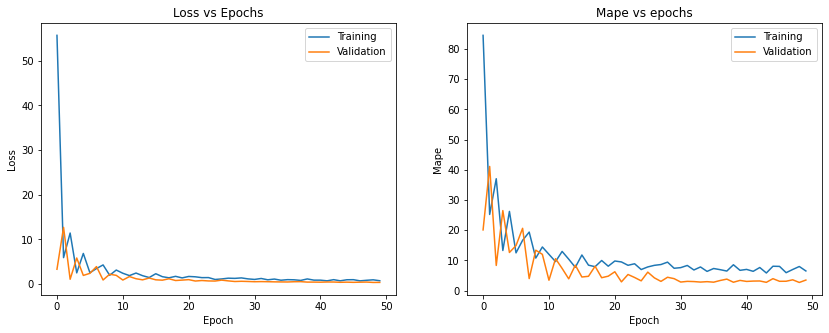

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
train_result=dict(zip(model.metrics_names,model.evaluate(layer_out_train_DS, y_train)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(layer_out_test_DS, y_test)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 0s 13ms/step - loss: 0.5102 - mape: 4.8210
Train_mape:4.82 	 Train_loss:0.51 

1/1 [==============================] - 0s 28ms/step - loss: 21.6003 - mape: 53.3364
Test_mape:53.34 	 Test_loss:21.60


In [ ]:
n=np.random.randint(0,layer_out_test_DS.shape[0],10)
print('feature= '+str(features[f]),'\n')
for i in range(10):
  prediction=model.predict(layer_out_test_DS[n[i]:n[i]+1])[0][0]
  real=y_test[n[i]]
  print(f'predicted value:{prediction:.2f}','\t',f'real value:{real:.2f}')

feature= protein 

predicted value:3.97 	 real value:8.84
predicted value:3.97 	 real value:8.23
predicted value:3.99 	 real value:8.11
predicted value:4.02 	 real value:9.69
predicted value:4.03 	 real value:8.27
predicted value:4.02 	 real value:7.88
predicted value:4.03 	 real value:8.27
predicted value:4.02 	 real value:9.69
predicted value:3.97 	 real value:8.42
predicted value:3.99 	 real value:8.11


In [ ]:
popt,pcov = curve_fit(my_func,y_test,model.predict(layer_out_test_DS).reshape(16,),p0,method='lm')
xfit=np.linspace(y_test.min()-0.2,y_test.max()+0.2,50)
yfit=my_func(xfit,popt[0],popt[1])

r^2 score:-92.37 



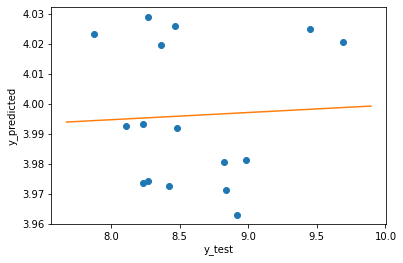

In [ ]:
print(f'r^2 score:{r2_score(y_test, model.predict(layer_out_test_DS)):.2f}', '\n')
plt.plot(y_test, model.predict(layer_out_test_DS), 'o')
plt.plot(xfit, yfit)
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.show()

###Data without preprocessing

In [ ]:
layer_out_train_DS=inception_module_DS(X_train_all_reshaped)
layer_out_test_DS=inception_module_DS(X_test_all_reshaped)

In [ ]:
compile_model_lr(model)
history=model.fit(layer_out_train_DS,y_train_all,batch_size=32,epochs=50,validation_split=0.15,verbose=0)

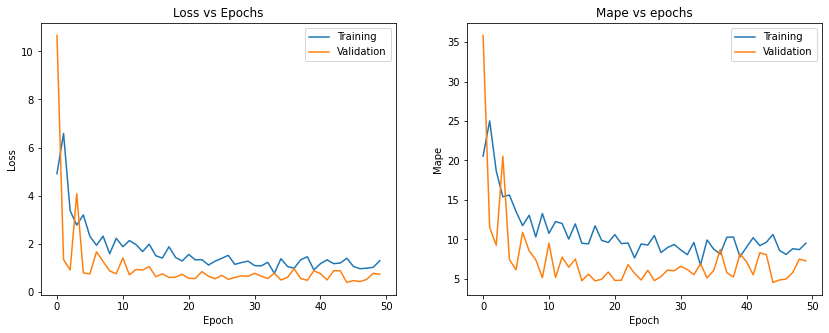

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
train_result=dict(zip(model.metrics_names,model.evaluate(layer_out_train_DS, y_train_all)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(layer_out_test_DS, y_test_all)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 0s 13ms/step - loss: 0.7739 - mape: 7.5539
Train_mape:7.55 	 Train_loss:0.77 

1/1 [==============================] - 0s 28ms/step - loss: 384.3770 - mape: 227.3721
Test_mape:227.37 	 Test_loss:384.38


In [ ]:
n=np.random.randint(0,layer_out_test_DS.shape[0],10)
print('feature= '+str(features[f]),'\n')
for i in range(10):
  prediction=model.predict(layer_out_test_DS[n[i]:n[i]+1])[0][0]
  real=y_test_all[n[i]]
  print(f'predicted value:{prediction:.2f}','\t',f'real value:{real:.2f}')

feature= protein 

predicted value:27.85 	 real value:8.47
predicted value:25.43 	 real value:8.27
predicted value:32.59 	 real value:8.82
predicted value:26.37 	 real value:8.23
predicted value:29.40 	 real value:9.45
predicted value:26.36 	 real value:8.23
predicted value:25.67 	 real value:8.11
predicted value:26.37 	 real value:8.23
predicted value:27.59 	 real value:8.99
predicted value:25.16 	 real value:8.27


In [ ]:
popt,pcov = curve_fit(my_func,y_test_all,model.predict(layer_out_test_DS).reshape(16,),p0,method='lm')
xfit=np.linspace(y_test_all.min()-0.2,y_test_all.max()+0.2,50)
yfit=my_func(xfit,popt[0],popt[1])

r^2 score:-1681.33 



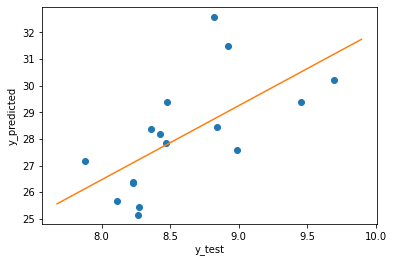

In [ ]:
print(f'r^2 score:{r2_score(y_test_all, model.predict(layer_out_test_DS)):.2f}', '\n')
plt.plot(y_test_all, model.predict(layer_out_test_DS), 'o')
plt.plot(xfit, yfit)
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.show()

###De acuerdo con los resultados obtenidos puede evidenciarse, que el modelo 1, el cual es el más simple en lo que respecta a su estructura, es aquel que proporciona los mejores resultandos de testeo, con $0.55$ en la función de perdida _MSE_ y $7.87$ para la metrica _MAPE_. El segundo modelo que proporciona mejores resultados es el modelo 3. A pesar de que el modelo DeepSpectra era mucho más complejo en su estructura, este no proporcionó mejores resultados en comparación con los otros modelos. El modelo DeepSpectra fue entrenado tanto con datos preprocesados, como no procesados y de acuerdo con los valores obtenidos para la función de perdida y la metrica, se observa claramente el efecto negativo de haber implementado dicho modelo con datos no procesados con anterioridad.

###Un efecto importante en el modelo DeepSpectra, es el ocasionado el eliminar el _learning rate decay_. Una vez este se elimina el comportamiento de la función de error y la metrica en función de los _epochs_ se _suaviza_, y ambos valores aminoran.

In [36]:
compile_model(model)
history=model.fit(layer_out_train_DS,y_train,batch_size=32,epochs=50,validation_split=0.15,verbose=0)

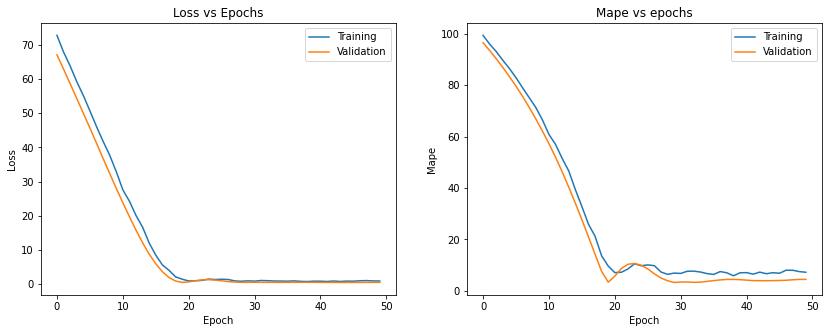

In [37]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss vs Epochs')
ax[0].set(xlabel='Epoch',ylabel='Loss')
ax[0].legend(['Training','Validation'], loc='upper right')
ax[1].plot(history.history['mape'])
ax[1].plot(history.history['val_mape'])
ax[1].set_title('Mape vs epochs')
ax[1].set(xlabel='Epoch',ylabel='Mape')
ax[1].legend(['Training','Validation'], loc='upper right')
plt.show()

In [38]:
train_result=dict(zip(model.metrics_names,model.evaluate(layer_out_train_DS, y_train)))
mape_train=train_result['mape']
loss_train=train_result['loss']
print(f'Train_mape:{mape_train:.2f}','\t',f'Train_loss:{loss_train:.2f}','\n')
test_result=dict(zip(model.metrics_names,model.evaluate(layer_out_test_DS, y_test)))
mape_test=test_result['mape']
loss_test=test_result['loss']
print(f'Test_mape:{mape_test:.2f}','\t',f'Test_loss:{loss_test:.2f}')

2/2 [==============================] - 0s 10ms/step - loss: 0.5402 - mape: 4.4044
Train_mape:4.40 	 Train_loss:0.54 

1/1 [==============================] - 0s 29ms/step - loss: 15.2042 - mape: 43.7915
Test_mape:43.79 	 Test_loss:15.20


###No debe perderse de vista que los valores de $R^{2}$ entre los valores predichos y de testeo, para todos los modelos son negativos, lo que indica que debe de realizarse un proceso más exaustivo en materia de limpieza de datos, o en la estructuración e implementación de modelos basados en redes neuronales.